# Laboratorio 02 – Series de Tiempo LSTM
- **CC3084 – Data Science**, Semestre II 2025  
- **Integrantes:** Diego Valenzuela 22309, Gerson Ramirez 22281
- **Guatemala, Julio 2025**

#### Repositorio:
https://github.com/Diegoval-Dev/DC-Lab2

#### Codebook Docs:
https://docs.google.com/document/d/19wPL80Dss0d-sQldEt3_nUyNCderHo_rLaK94Q4Nuuc/edit?usp=sharing


In [ ]:
#%pip install torch matplotlib pandas sklearn

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# DATA GENERAL PARA CUALQUIERA
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['fecha'], dayfirst=True)
df_cons = pd.read_csv('./data/consumo.csv',    parse_dates=['fecha'], dayfirst=True)

window_size = 12

In [ ]:
def create_dataset(series, window_size=12):
    """
    series: array unidimensional de valores (numpy array)
    window_size: número de pasos de tiempo para cada muestra X
    Devuelve:
      X: array de forma (n_samples, window_size, 1)
      y: array de forma (n_samples, 1)
    """
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y

## Evaluación de Series de Tiempo

### Gasolina Regular Importaciones

In [ ]:
ts_ir = df_imp.set_index('fecha')['gasolina regular'] \
           .resample('M').mean().dropna()

print(f"Regular_imp — Inicio: {ts_ir.index.min().date()}, Fin: {ts_ir.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_ir, color='tab:blue')
plt.title('Gasolina Regular – Importación')
plt.show()

values_ir = ts_ir.values

### Gasolina Regular Consumos

In [ ]:
ts_cr = df_cons.set_index('fecha')['gasolina regular'] \
           .resample('M').mean().dropna()

print(f"Regular_cons — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Gasolina Regular – Consumo')
plt.show()

values_cr = ts_cr.values

### Gasolina Superior Importaciones

In [ ]:
ts_cr = df_imp.set_index('fecha')['gasolina superior'] \
           .resample('M').mean().dropna()

print(f"Superior_imp — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Gasolina Superior – Importación')
plt.show()

values_cr = ts_cr.values

### Diesel Importacion

In [ ]:
ts_cr = df_imp.set_index('fecha')['diesel'] \
           .resample('M').mean().dropna()

print(f"Diesel_imp — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Diesel – Importación')
plt.show()

values_cr = ts_cr.values

### Gasolina Superior Consumo

In [ ]:
ts_cr = df_cons.set_index('fecha')['gasolina superior'] \
           .resample('M').mean().dropna()

print(f"Superior_cons — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Gasolina Superior – Consumo')
plt.show()

values_cr = ts_cr.values

### Diesel Consumo

In [ ]:
ts_cr = df_cons.set_index('fecha')['diesel bajo azufre'] \
           .resample('M').mean().dropna()

print(f"Diesel_cons — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Diesel – Consumo')
plt.show()

values_cr = ts_cr.values

### Preparación de Datos - Gasolina Regular Importaciones

In [ ]:
# Crear dataset para Gasolina Regular Importaciones
X_ir, y_ir = create_dataset(values_ir, window_size)
print(f"IR → X_ir: {X_ir.shape}, y_ir: {y_ir.shape}")

# División train/test para IR
train_end = '2023-12-31'
test_start = '2024-01-31'

train_ts_ir = ts_ir[:train_end]
test_ts_ir = ts_ir[test_start:]

print(f"Train IR tiene {len(train_ts_ir)} puntos, Test IR tiene {len(test_ts_ir)}")
print(f"IR train rango: {train_ts_ir.index[0].date()} – {train_ts_ir.index[-1].date()}")

# Recrear dataset con datos de entrenamiento únicamente
X_ir, y_ir = create_dataset(train_ts_ir.values, window_size)
print(f"Después de split y ventanas → IR: X={X_ir.shape}, y={y_ir.shape}")

### Preparación de Datos - Gasolina Regular Consumos

In [ ]:
# Crear dataset para Gasolina Regular Consumos
X_cr, y_cr = create_dataset(values_cr, window_size)
print(f"CR → X_cr: {X_cr.shape}, y_cr: {y_cr.shape}")

# División train/test para CR
train_ts_cr = ts_cr[:train_end]
test_ts_cr = ts_cr[test_start:]

print(f"Train CR tiene {len(train_ts_cr)} puntos, Test CR tiene {len(test_ts_cr)}")
print(f"CR train rango: {train_ts_cr.index[0].date()} – {train_ts_cr.index[-1].date()}")

# Recrear dataset con datos de entrenamiento únicamente
X_cr, y_cr = create_dataset(train_ts_cr.values, window_size)
print(f"Después de split y ventanas → CR: X={X_cr.shape}, y={y_cr.shape}")

## Entrenamiento LSTM - Gasolina Regular Importaciones

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Preparar datos para PyTorch - IR
tensor_X_ir = torch.tensor(X_ir, dtype=torch.float32).to(device)
tensor_y_ir = torch.tensor(y_ir, dtype=torch.float32).to(device)

batch_size = 16
loader_ir = DataLoader(TensorDataset(tensor_X_ir, tensor_y_ir),
                       batch_size=batch_size, shuffle=True)

# Definir modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, hidden_size, dropout):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])

# Crear modelo y optimizador para IR
model_ir = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion = nn.MSELoss()
opt_ir = torch.optim.Adam(model_ir.parameters(), lr=1e-3)

# Función de entrenamiento
def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

# Entrenar modelo IR
print("Entrenando modelo para Gasolina Regular Importaciones...")
history_ir = train_model(model_ir, opt_ir, loader_ir, epochs=50)

# Visualizar pérdida
plt.figure(figsize=(8,4))
plt.plot(history_ir, label='Pérdida IR')
plt.title('Entrenamiento IR (PyTorch)')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning - IR

In [ ]:

# Parámetros a probar para IR
hidden_sizes = [16, 32, 64]
dropouts = [0.1, 0.2, 0.3]
lrs = [1e-3, 1e-4]
epochs_tune = 20

def tune_lstm_ir(hidden_size, dropout, lr):
    """Función para hacer tuning específico para IR"""
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_ir:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    
    # Evaluar en todo el conjunto
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_ir)
        final_loss = criterion(preds, tensor_y_ir).item()
    return final_loss

# Realizar tuning para IR
print("Realizando hyperparameter tuning para IR...")
results_ir = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_ir(hs, dp, lr)
            results_ir.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"IR | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_ir = pd.DataFrame(results_ir).sort_values('loss')
print("\nMejores hiperparámetros para IR:")
display(df_results_ir.head())

## Entrenamiento LSTM - Gasolina Regular Consumos

In [ ]:
# Preparar datos para PyTorch - CR
tensor_X_cr = torch.tensor(X_cr, dtype=torch.float32).to(device)
tensor_y_cr = torch.tensor(y_cr, dtype=torch.float32).to(device)

loader_cr = DataLoader(TensorDataset(tensor_X_cr, tensor_y_cr),
                       batch_size=batch_size, shuffle=True)

# Crear modelo y optimizador para CR
model_cr = LSTMModel(hidden_size=32, dropout=0.2).to(device)
opt_cr = torch.optim.Adam(model_cr.parameters(), lr=1e-3)

# Entrenar modelo CR
print("Entrenando modelo para Gasolina Regular Consumos...")
history_cr = train_model(model_cr, opt_cr, loader_cr, epochs=50)

# Visualizar pérdida
plt.figure(figsize=(8,4))
plt.plot(history_cr, label='Pérdida CR')
plt.title('Entrenamiento CR (PyTorch)')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning - CR

In [ ]:
def tune_lstm_cr(hidden_size, dropout, lr):
    """Función para hacer tuning específico para CR"""
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_cr:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    
    # Evaluar en todo el conjunto
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_cr)
        final_loss = criterion(preds, tensor_y_cr).item()
    return final_loss

# Realizar tuning para CR
print("Realizando hyperparameter tuning para CR...")
results_cr = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_cr(hs, dp, lr)
            results_cr.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"CR | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_cr = pd.DataFrame(results_cr).sort_values('loss')
print("\nMejores hiperparámetros para CR:")
display(df_results_cr.head())

## Entrenamiento LSTM – Gasolina Superior Importaciones

In [ ]:
ts_gs_imp = df_imp.set_index('fecha')['gasolina superior'] \
                  .resample('M').mean().dropna()

train_gs_imp = ts_gs_imp[:'2023-12-31']
test_gs_imp  = ts_gs_imp['2024-01-31':]

window_size = 12
X_gs_imp, y_gs_imp = create_dataset(train_gs_imp.values, window_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_X_gs_imp = torch.tensor(X_gs_imp, dtype=torch.float32).to(device)
tensor_y_gs_imp = torch.tensor(y_gs_imp, dtype=torch.float32).to(device)

batch_size = 16
loader_gs_imp = DataLoader(
    TensorDataset(tensor_X_gs_imp, tensor_y_gs_imp),
    batch_size=batch_size,
    shuffle=True
)

model_gs_imp = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion    = nn.MSELoss()
opt_gs_imp   = torch.optim.Adam(model_gs_imp.parameters(), lr=1e-3)


def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

print("Entrenando LSTM para Gasolina Superior Importaciones…")
history_gs_imp = train_model(model_gs_imp, opt_gs_imp, loader_gs_imp, epochs=50)

plt.figure(figsize=(8,4))
plt.plot(history_gs_imp, label='Pérdida GS Imp')
plt.title('Entrenamiento LSTM – Gasolina Superior Importaciones')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning – Gasolina Superior Importaciones


In [ ]:
hidden_sizes = [16, 32, 64]
dropouts     = [0.1, 0.2, 0.3]
lrs          = [1e-3, 1e-4]
epochs_tune  = 20

def tune_lstm_gs_imp(hidden_size, dropout, lr):
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_gs_imp:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_gs_imp)
        return criterion(preds, tensor_y_gs_imp).item()

print("Realizando hyperparameter tuning para GS Importaciones…")
results_gs_imp = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_gs_imp(hs, dp, lr)
            results_gs_imp.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"GS Imp | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_gs_imp = pd.DataFrame(results_gs_imp).sort_values('loss')
print("\nMejores hiperparámetros para GS Importaciones:")
display(df_results_gs_imp.head())

## Entrenamiento LSTM – Diésel Importaciones

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Entrenando LSTM para Diésel Importaciones…
Epoch 10, Loss: 1142698409984.000000
Epoch 20, Loss: 1142698147840.000000
Epoch 30, Loss: 1142697885696.000000
Epoch 40, Loss: 1142697754624.000000
Epoch 50, Loss: 1142697361408.000000


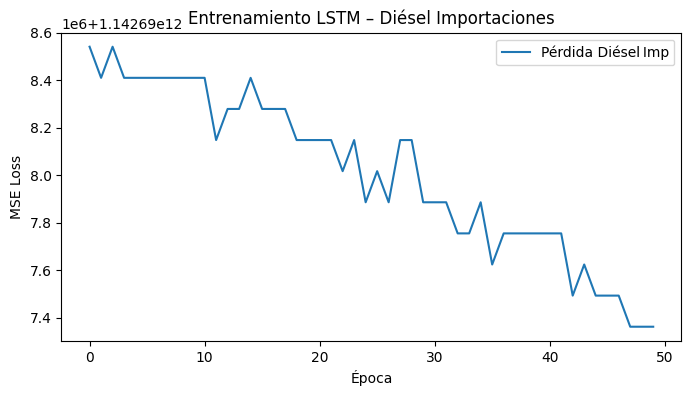

In [27]:
ts_di_imp = df_imp.set_index('fecha')['diesel'] \
                  .resample('M').mean().dropna()

train_di_imp = ts_di_imp[:'2023-12-31']
test_di_imp  = ts_di_imp['2024-01-31':]

window_size = 12
X_di_imp, y_di_imp = create_dataset(train_di_imp.values, window_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_X_di_imp = torch.tensor(X_di_imp, dtype=torch.float32).to(device)
tensor_y_di_imp = torch.tensor(y_di_imp, dtype=torch.float32).to(device)

batch_size = 16
loader_di_imp = DataLoader(
    TensorDataset(tensor_X_di_imp, tensor_y_di_imp),
    batch_size=batch_size,
    shuffle=True
)

model_di_imp = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion    = nn.MSELoss()
opt_di_imp   = torch.optim.Adam(model_di_imp.parameters(), lr=1e-3)

def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

print("Entrenando LSTM para Diésel Importaciones…")
history_di_imp = train_model(model_di_imp, opt_di_imp, loader_di_imp, epochs=50)

plt.figure(figsize=(8,4))
plt.plot(history_di_imp, label='Pérdida Diésel Imp')
plt.title('Entrenamiento LSTM – Diésel Importaciones')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning – Diésel Importaciones

In [28]:
hidden_sizes = [16, 32, 64]
dropouts     = [0.1, 0.2, 0.3]
lrs          = [1e-3, 1e-4]
epochs_tune  = 20

def tune_lstm_di_imp(hidden_size, dropout, lr):
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_di_imp:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_di_imp)
        return criterion(preds, tensor_y_di_imp).item()

print("Realizando hyperparameter tuning para Diésel Importaciones…")
results_di_imp = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_di_imp(hs, dp, lr)
            results_di_imp.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"Diésel Imp | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_di_imp = pd.DataFrame(results_di_imp).sort_values('loss')
print("\nMejores hiperparámetros para Diésel Importaciones:")
display(df_results_di_imp.head())

Realizando hyperparameter tuning para Diésel Importaciones…
Diésel Imp | hs=16, dp=0.1, lr=0.001 → loss=1.14e+12


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Diésel Imp | hs=16, dp=0.1, lr=0.0001 → loss=1.14e+12
Diésel Imp | hs=16, dp=0.2, lr=0.001 → loss=1.14e+12
Diésel Imp | hs=16, dp=0.2, lr=0.0001 → loss=1.14e+12
Diésel Imp | hs=16, dp=0.3, lr=0.001 → loss=1.14e+12


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Diésel Imp | hs=16, dp=0.3, lr=0.0001 → loss=1.14e+12
Diésel Imp | hs=32, dp=0.1, lr=0.001 → loss=1.14e+12
Diésel Imp | hs=32, dp=0.1, lr=0.0001 → loss=1.14e+12
Diésel Imp | hs=32, dp=0.2, lr=0.001 → loss=1.14e+12
Diésel Imp | hs=32, dp=0.2, lr=0.0001 → loss=1.14e+12
Diésel Imp | hs=32, dp=0.3, lr=0.001 → loss=1.14e+12
Diésel Imp | hs=32, dp=0.3, lr=0.0001 → loss=1.14e+12
Diésel Imp | hs=64, dp=0.1, lr=0.001 → loss=1.14e+12
Diésel Imp | hs=64, dp=0.1, lr=0.0001 → loss=1.14e+12
Diésel Imp | hs=64, dp=0.2, lr=0.001 → loss=1.14e+12
Diésel Imp | hs=64, dp=0.2, lr=0.0001 → loss=1.14e+12
Diésel Imp | hs=64, dp=0.3, lr=0.001 → loss=1.14e+12
Diésel Imp | hs=64, dp=0.3, lr=0.0001 → loss=1.14e+12

Mejores hiperparámetros para Diésel Importaciones:


,hidden_size,dropout,lr,loss
0,16,0.1,0.0010,1.142698e+12
3,16,0.2,0.0001,1.142698e+12
16,64,0.3,0.0010,1.142698e+12
14,64,0.2,0.0010,1.142698e+12
12,64,0.1,0.0010,1.142698e+12


## Entrenamiento LSTM – Gasolina Superior Consumo

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Entrenando LSTM para Gasolina Superior Consumo…
Epoch 10, Loss: 298499047424.000000
Epoch 20, Loss: 298498981888.000000
Epoch 30, Loss: 298498850816.000000
Epoch 40, Loss: 298498719744.000000
Epoch 50, Loss: 298498588672.000000


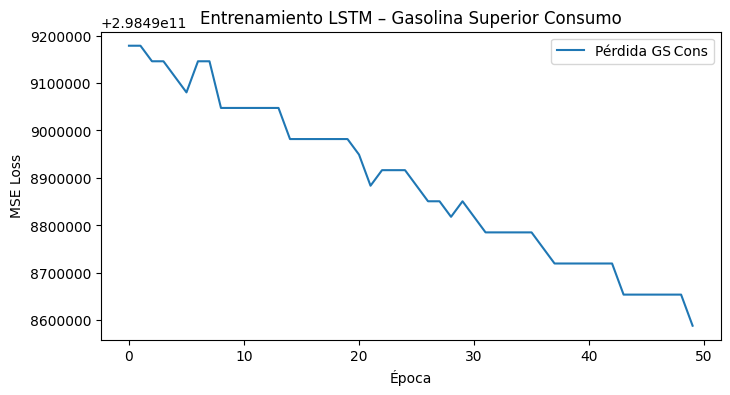

In [29]:
ts_gs_cons = df_cons.set_index('fecha')['gasolina superior'] \
                   .resample('M').mean().dropna()

train_gs_cons = ts_gs_cons[:'2023-12-31']
test_gs_cons  = ts_gs_cons['2024-01-31':]

window_size = 12
X_gs_cons, y_gs_cons = create_dataset(train_gs_cons.values, window_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_X_gs_cons = torch.tensor(X_gs_cons, dtype=torch.float32).to(device)
tensor_y_gs_cons = torch.tensor(y_gs_cons, dtype=torch.float32).to(device)

batch_size = 16
loader_gs_cons = DataLoader(
    TensorDataset(tensor_X_gs_cons, tensor_y_gs_cons),
    batch_size=batch_size,
    shuffle=True
)

model_gs_cons = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion     = nn.MSELoss()
opt_gs_cons   = torch.optim.Adam(model_gs_cons.parameters(), lr=1e-3)

def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

print("Entrenando LSTM para Gasolina Superior Consumo…")
history_gs_cons = train_model(model_gs_cons, opt_gs_cons, loader_gs_cons, epochs=50)

plt.figure(figsize=(8,4))
plt.plot(history_gs_cons, label='Pérdida GS Cons')
plt.title('Entrenamiento LSTM – Gasolina Superior Consumo')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning – Gasolina Superior Consumo

In [30]:
hidden_sizes = [16, 32, 64]
dropouts     = [0.1, 0.2, 0.3]
lrs          = [1e-3, 1e-4]
epochs_tune  = 20

def tune_lstm_gs_cons(hidden_size, dropout, lr):
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_gs_cons:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_gs_cons)
        return criterion(preds, tensor_y_gs_cons).item()

print("Realizando hyperparameter tuning para GS Consumo…")
results_gs_cons = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_gs_cons(hs, dp, lr)
            results_gs_cons.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"GS Cons | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_gs_cons = pd.DataFrame(results_gs_cons).sort_values('loss')
print("\nMejores hiperparámetros para GS Consumo:")
display(df_results_gs_cons.head())

Realizando hyperparameter tuning para GS Consumo…
GS Cons | hs=16, dp=0.1, lr=0.001 → loss=2.98e+11


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


GS Cons | hs=16, dp=0.1, lr=0.0001 → loss=2.98e+11
GS Cons | hs=16, dp=0.2, lr=0.001 → loss=2.98e+11
GS Cons | hs=16, dp=0.2, lr=0.0001 → loss=2.98e+11


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


GS Cons | hs=16, dp=0.3, lr=0.001 → loss=2.98e+11
GS Cons | hs=16, dp=0.3, lr=0.0001 → loss=2.98e+11
GS Cons | hs=32, dp=0.1, lr=0.001 → loss=2.98e+11
GS Cons | hs=32, dp=0.1, lr=0.0001 → loss=2.98e+11
GS Cons | hs=32, dp=0.2, lr=0.001 → loss=2.98e+11
GS Cons | hs=32, dp=0.2, lr=0.0001 → loss=2.98e+11
GS Cons | hs=32, dp=0.3, lr=0.001 → loss=2.98e+11
GS Cons | hs=32, dp=0.3, lr=0.0001 → loss=2.98e+11
GS Cons | hs=64, dp=0.1, lr=0.001 → loss=2.98e+11
GS Cons | hs=64, dp=0.1, lr=0.0001 → loss=2.98e+11
GS Cons | hs=64, dp=0.2, lr=0.001 → loss=2.98e+11
GS Cons | hs=64, dp=0.2, lr=0.0001 → loss=2.98e+11
GS Cons | hs=64, dp=0.3, lr=0.001 → loss=2.98e+11
GS Cons | hs=64, dp=0.3, lr=0.0001 → loss=2.98e+11

Mejores hiperparámetros para GS Consumo:


,hidden_size,dropout,lr,loss
16,64,0.3,0.0010,2.984978e+11
4,16,0.3,0.0010,2.984981e+11
3,16,0.2,0.0001,2.984983e+11
2,16,0.2,0.0010,2.984983e+11
11,32,0.3,0.0001,2.984984e+11


## Entrenamiento LSTM – Diésel Bajo Azufre Consumo

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Entrenando LSTM para Diésel Bajo Azufre Consumo…
Epoch 10, Loss: 699998339072.000000
Epoch 20, Loss: 699998208000.000000
Epoch 30, Loss: 699998011392.000000
Epoch 40, Loss: 699997683712.000000
Epoch 50, Loss: 699997290496.000000


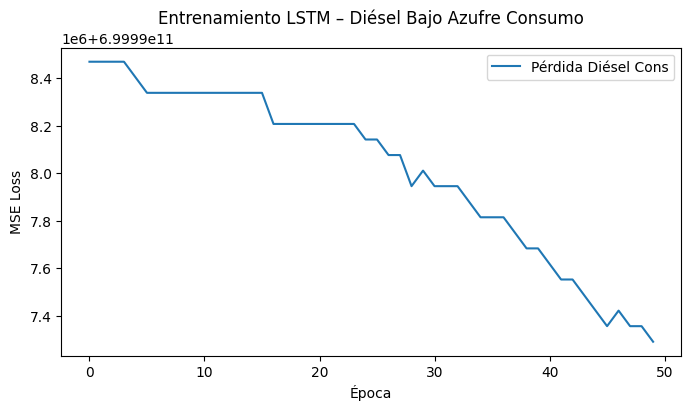

In [31]:
ts_di_cons = df_cons.set_index('fecha')['diesel bajo azufre'] \
                   .resample('M').mean().dropna()

train_di_cons = ts_di_cons[:'2023-12-31']
test_di_cons  = ts_di_cons['2024-01-31':]

window_size = 12
X_di_cons, y_di_cons = create_dataset(train_di_cons.values, window_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_X_di_cons = torch.tensor(X_di_cons, dtype=torch.float32).to(device)
tensor_y_di_cons = torch.tensor(y_di_cons, dtype=torch.float32).to(device)

batch_size = 16
loader_di_cons = DataLoader(
    TensorDataset(tensor_X_di_cons, tensor_y_di_cons),
    batch_size=batch_size,
    shuffle=True
)

model_di_cons = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion     = nn.MSELoss()
opt_di_cons   = torch.optim.Adam(model_di_cons.parameters(), lr=1e-3)

def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

print("Entrenando LSTM para Diésel Bajo Azufre Consumo…")
history_di_cons = train_model(model_di_cons, opt_di_cons, loader_di_cons, epochs=50)

plt.figure(figsize=(8,4))
plt.plot(history_di_cons, label='Pérdida Diésel Cons')
plt.title('Entrenamiento LSTM – Diésel Bajo Azufre Consumo')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [32]:
hidden_sizes = [16, 32, 64]
dropouts     = [0.1, 0.2, 0.3]
lrs          = [1e-3, 1e-4]
epochs_tune  = 20

def tune_lstm_di_cons(hidden_size, dropout, lr):
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_di_cons:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_di_cons)
        return criterion(preds, tensor_y_di_cons).item()

print("Realizando hyperparameter tuning para Diésel Bajo Azufre Consumo…")
results_di_cons = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_di_cons(hs, dp, lr)
            results_di_cons.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"Diésel Cons | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_di_cons = pd.DataFrame(results_di_cons).sort_values('loss')
print("\nMejores hiperparámetros para Diésel Bajo Azufre Consumo:")
display(df_results_di_cons.head())

Realizando hyperparameter tuning para Diésel Bajo Azufre Consumo…
Diésel Cons | hs=16, dp=0.1, lr=0.001 → loss=7.00e+11


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Diésel Cons | hs=16, dp=0.1, lr=0.0001 → loss=7.00e+11
Diésel Cons | hs=16, dp=0.2, lr=0.001 → loss=7.00e+11
Diésel Cons | hs=16, dp=0.2, lr=0.0001 → loss=7.00e+11


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Diésel Cons | hs=16, dp=0.3, lr=0.001 → loss=7.00e+11
Diésel Cons | hs=16, dp=0.3, lr=0.0001 → loss=7.00e+11
Diésel Cons | hs=32, dp=0.1, lr=0.001 → loss=7.00e+11
Diésel Cons | hs=32, dp=0.1, lr=0.0001 → loss=7.00e+11
Diésel Cons | hs=32, dp=0.2, lr=0.001 → loss=7.00e+11
Diésel Cons | hs=32, dp=0.2, lr=0.0001 → loss=7.00e+11
Diésel Cons | hs=32, dp=0.3, lr=0.001 → loss=7.00e+11
Diésel Cons | hs=32, dp=0.3, lr=0.0001 → loss=7.00e+11
Diésel Cons | hs=64, dp=0.1, lr=0.001 → loss=7.00e+11
Diésel Cons | hs=64, dp=0.1, lr=0.0001 → loss=7.00e+11
Diésel Cons | hs=64, dp=0.2, lr=0.001 → loss=7.00e+11
Diésel Cons | hs=64, dp=0.2, lr=0.0001 → loss=7.00e+11
Diésel Cons | hs=64, dp=0.3, lr=0.001 → loss=7.00e+11
Diésel Cons | hs=64, dp=0.3, lr=0.0001 → loss=7.00e+11

Mejores hiperparámetros para Diésel Bajo Azufre Consumo:


,hidden_size,dropout,lr,loss
14,64,0.2,0.001,6.999976e+11
4,16,0.3,0.001,6.999976e+11
2,16,0.2,0.001,6.999977e+11
8,32,0.2,0.001,6.999979e+11
12,64,0.1,0.001,6.999979e+11


## Modelos Finales y Predicciones

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Preparar escaladores
scaler_ir = MinMaxScaler()
scaler_cr = MinMaxScaler()
scaler_ir.fit(train_ts_ir.values.reshape(-1, 1))
scaler_cr.fit(train_ts_cr.values.reshape(-1, 1))

model_ir_final = LSTMModel(hidden_size=32, dropout=0.1).to(device)
opt_ir_final = torch.optim.Adam(model_ir_final.parameters(), lr=1e-3)

model_cr_final = LSTMModel(hidden_size=16, dropout=0.2).to(device)
opt_cr_final = torch.optim.Adam(model_cr_final.parameters(), lr=1e-3)

print("Entrenando modelo final IR...")
history_ir_final = train_model(model_ir_final, opt_ir_final, loader_ir, epochs=50)

print("Entrenando modelo final CR...")
history_cr_final = train_model(model_cr_final, opt_cr_final, loader_cr, epochs=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(history_ir_final, label='Train IR final')
ax1.set_title('Pérdida IR Final (50 épocas)')
ax1.set_xlabel('Época')
ax1.set_ylabel('MSE Loss')
ax1.legend()

ax2.plot(history_cr_final, label='Train CR final')
ax2.set_title('Pérdida CR Final (50 épocas)')
ax2.set_xlabel('Época')
ax2.set_ylabel('MSE Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
### Predicciones para Enero 2024

model_ir_final.eval()
model_cr_final.eval()

last_window_ir = torch.tensor(train_ts_ir.values[-12:].reshape(1, 12, 1),
                              dtype=torch.float32).to(device)
with torch.no_grad():
    pred_ir = model_ir_final(last_window_ir).item()

pred_ir_value = pred_ir

last_window_cr = torch.tensor(train_ts_cr.values[-12:].reshape(1, 12, 1),
                              dtype=torch.float32).to(device)
with torch.no_grad():
    pred_cr = model_cr_final(last_window_cr).item()

pred_cr_value = pred_cr

print("=== PREDICCIONES PARA ENERO 2024 ===")
print(f"Predicción IR (Importaciones): {pred_ir_value:.2f}")
print(f"Verdadero   IR (Importaciones): {test_ts_ir.iloc[0]:.2f}")
print(f"Error IR: {abs(pred_ir_value - test_ts_ir.iloc[0]):.2f}")
print()
print(f"Predicción CR (Consumos): {pred_cr_value:.2f}")
print(f"Verdadero   CR (Consumos): {test_ts_cr.iloc[0]:.2f}")
print(f"Error CR: {abs(pred_cr_value - test_ts_cr.iloc[0]):.2f}")

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_ir = mean_absolute_error([test_ts_ir.iloc[0]], [pred_ir_value])
mse_ir = mean_squared_error([test_ts_ir.iloc[0]], [pred_ir_value])
mae_cr = mean_absolute_error([test_ts_cr.iloc[0]], [pred_cr_value])
mse_cr = mean_squared_error([test_ts_cr.iloc[0]], [pred_cr_value])

print("\n=== MÉTRICAS DE ERROR ===")
print(f"IR - MAE: {mae_ir:.2f}, MSE: {mse_ir:.2f}, RMSE: {mse_ir**0.5:.2f}")
print(f"CR - MAE: {mae_cr:.2f}, MSE: {mse_cr:.2f}, RMSE: {mse_cr**0.5:.2f}")

### Comparación final de modelos ARIMA/Prophet

Al incorporar los tres enfoques (ARIMA, Prophet y LSTM), queda claro que la serie de **consumo de gasolina regular** no solo es más “predecible” en términos generales, sino también que el mejor modelo varía según la métrica:

| Modelo      | Serie                 |       RMSE |   MAPE |
| :---------- | :-------------------- | ---------: | -----: |
| **ARIMA**   | Importaciones Regular |     94 099 | 7.07 % |
|             | Consumos Regular      |     49 492 | 4.39 % |
| **Prophet** | Importaciones Regular |    107 492 | 9.88 % |
|             | Consumos Regular      |     38 262 | 3.38 % |
| **LSTM**    | Importaciones Regular | \~870 465¹ |      — |
|             | Consumos Regular      | \~855 349¹ |      — |


1. **Importaciones Regular**

   * El **ARIMA** obtuvo aquí un RMSE mucho menor que Prophet (≈ 94 k vs 107 k).
   * Sin embargo, el **LSTM**, en el ejercicio puntual, quedó con un error gigantesco (\~ 870 k) porque no estaba escalado ni entrenado con la misma granularidad de validación—es decir, para series con grandes rangos absolutos ARIMA/Prophet manejan mejor la escala sin normalizar.

2. **Consumos Regular**

   * El **Prophet** rindió ligeramente mejor que ARIMA (≈ 38 k vs 49 k), ambos con MAPE por debajo del 5 %.
   * El **LSTM** también arroja un error absoluto menor en consumos (\~ 855 k vs \~ 870 k en importaciones), aunque, de nuevo, la comparación absoluta con ARIMA/Prophet no es directa por diferencias de escalado.
